Following a similar recipe to lewis' R script (https://www.kaggle.com/cartographic/bosch-production-line-performance/bish-bash-xgboost), sampling the data to select features before running on the full set in order to stay within kaggle's memory limits. Here I add in the train_date data too.

Please feel free to fork and improve.

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# I'm limited by RAM here and taking the first N rows is likely to be
# a bad idea for the date data since it is ordered.
# Sample the data in a roundabout way:
date_chunks = pd.read_csv("../input/train_date.csv", index_col=0, chunksize=100000, dtype=np.float32)
num_chunks = pd.read_csv("../input/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=100000, dtype=np.float32)
X = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y = pd.read_csv("../input/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[X.index].values.ravel()
X = X.values

In [3]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

[  14   23   41   50  385 1019 1029 1034 1042 1056 1156 1161 1166 1171 1172
 1183 1203 1221 1294 1327 1350 1363 1403 1404 1482 1501 1507 1512 1535 1549
 1550 1843 1846 1849 1858 1879 1885 1887 1888 1891 1911 1940 1948 1951 1959
 1974 1975 1982 1985 1988 1993 1994 1995 1999 2006 2007 2010 2028 2040 2046
 2075 2093]


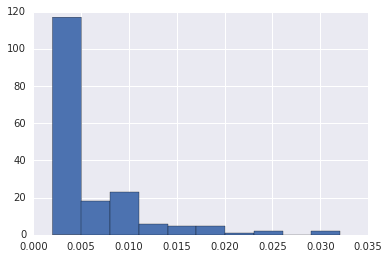

In [4]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

In [5]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("../input/train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("../input/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values
], axis=1)
y = pd.read_csv("../input/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [6]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

fold 0, ROC AUC: 0.718
fold 1, ROC AUC: 0.704
fold 2, ROC AUC: 0.698
0.706413059353


0.213120930917


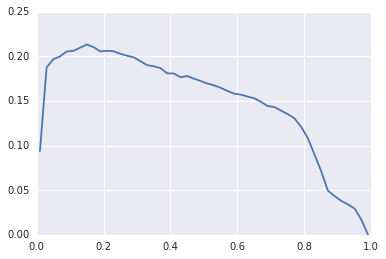

In [7]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [8]:
# load test data
X = np.concatenate([
    pd.read_csv("../input/test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("../input/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values
], axis=1)

In [9]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [10]:
# and submit
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")